In [41]:
import numpyro
import jax
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns
import arviz as az

In [6]:
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""

In [7]:
df = pd.read_csv(io.StringIO(golf_data), sep=' ')

In [8]:
df

,distance,tries,successes
0,2,1443,1346
1,3,694,577
2,4,455,337
3,5,353,208
4,6,272,149
5,7,256,136
6,8,240,111
7,9,217,69
8,10,200,67
9,11,237,75


In [9]:
# let's just try a binomial for now

In [53]:
def model(distance, tries, successes=None):
    
    α = numpyro.sample(
        'α',
        numpyro.distributions.Normal(0, .5),
    )
    β = numpyro.sample(
        'β',
        numpyro.distributions.Normal(0, .5),
    )
    
    probs = numpyro.deterministic(
        'probs',
        jax.scipy.special.expit(α + β*distance)
    )
    
    numpyro.sample(
        'obs',
        numpyro.distributions.Binomial(tries, probs),
        obs=successes,
    )

In [54]:
prior_pred = numpyro.infer.Predictive(model, num_samples=100)
prior_samples = prior_pred(
    jax.random.PRNGKey(0),
    distance=df['distance'].to_numpy(),
    tries=df['tries'].to_numpy(),
)

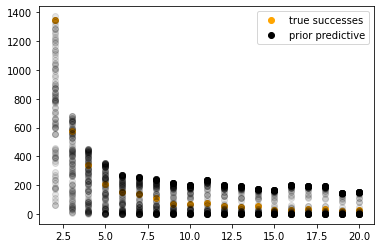

In [55]:
fig, ax = plt.subplots()

ax.plot(df['distance'], df['successes'], 'o', color='orange', label='true successes')
ax.plot(df['distance'], prior_samples['obs'].T, 'o', alpha=.1, color='black')
ax.plot([], [], 'o', color='black', label='prior predictive');
ax.legend();

In [56]:
# let's just choose one distance. Like...10 feet away.

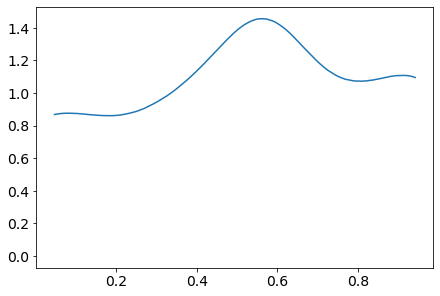

In [57]:
az.plot_kde(prior_samples['probs'][:, 0]);